Unique Pixel Values: {-128, 0, 71, 41, 42, 11, 43, 81, 82, 52, 21, 22, 23, 24, 90, 95, 31}


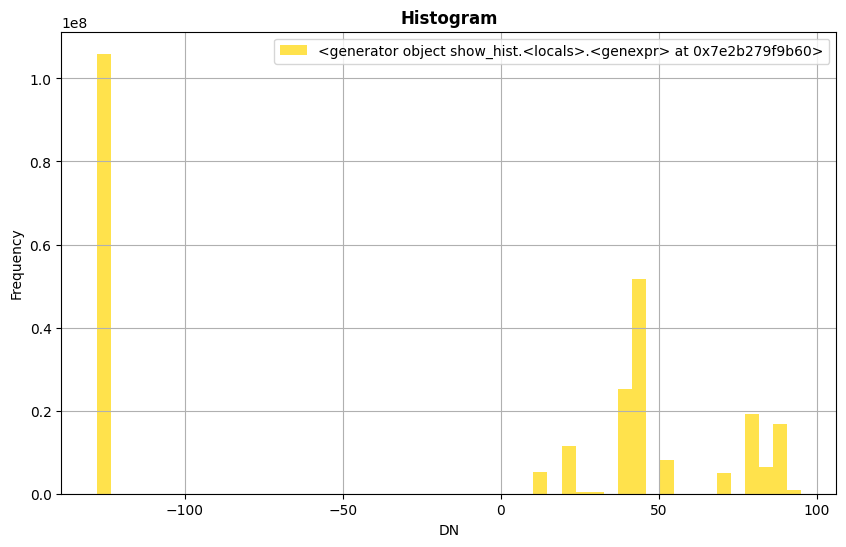

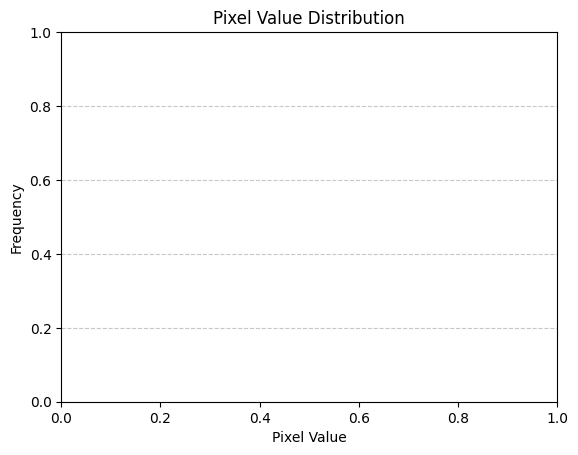

In [6]:
#Finding out the unique pixel values to determine areas with forests
import rasterio
from rasterio.plot import show_hist
import matplotlib.pyplot as plt

# Specify the path to your land cover data
land_cover_path = "/content/nlcd_al_utm16.tif"

# Open the land cover data using rasterio
with rasterio.open(land_cover_path) as src:
    # Read the data
    land_cover_data = src.read(1)

    # Display unique pixel values
    unique_pixel_values = set(land_cover_data.flatten())
    print("Unique Pixel Values:", unique_pixel_values)

    # Create a histogram to observe pixel value distribution
    plt.figure(figsize=(10, 6))
    show_hist(land_cover_data, bins=50, histtype='stepfilled', lw=0.5, alpha=0.7)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
#checking the data integrity
with rasterio.open(land_cover_path) as src:
    print(src.profile)  # Print raster profile information


{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -128.0, 'width': 13141, 'height': 19580, 'count': 1, 'crs': CRS.from_epsg(26916), 'transform': Affine(30.0, 0.0, 339504.37126904866,
       0.0, -30.0, 3894531.1081048716), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [ ]:
#checking if the CRS (Coordinate Reference System) of the three data is the same
print("Soil Data CRS:", soil_data.crs)
print("Hydrography Data CRS:", hydrography_data.crs)
print("Suitable Areas CRS:", suitable_areas.crs)


Soil Data CRS: PROJCS["NAD83 / Alabama West",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",30],PARAMETER["central_meridian",-87.5],PARAMETER["scale_factor",0.999933333333333],PARAMETER["false_easting",600000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Hydrography Data CRS: PROJCS["NAD83 / Alabama West",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",30],PARAMETER["central_meridian",-87.5],PARAMETER["scale_factor",0.999933333333333],PARAMETER["false_easting",600000],PARAMETER["false_nort

Total Number of Suitable Areas: 3498


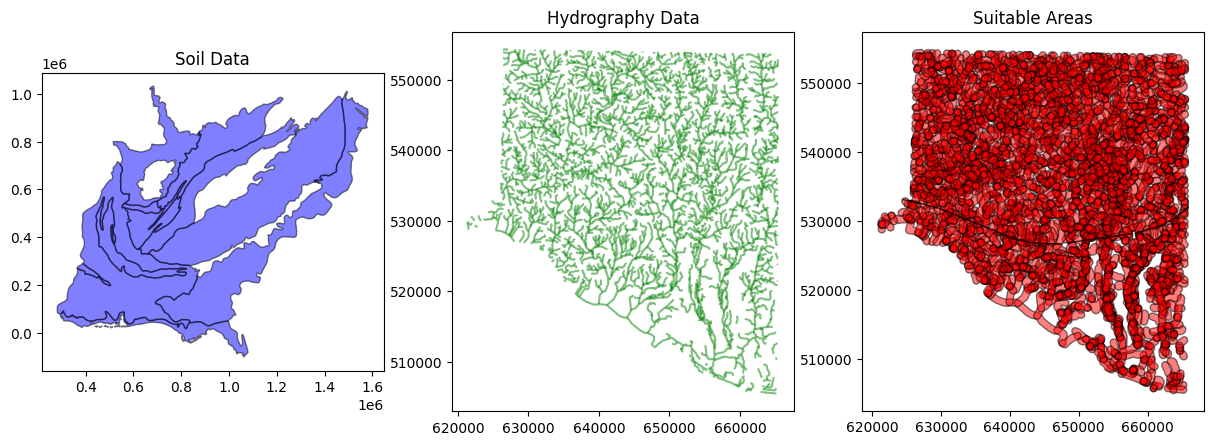

In [11]:
import pyproj
import geopandas as gpd
import rasterio
import folium
from folium import plugins
from shapely.geometry import Point
import matplotlib.pyplot as plt


# Plot each layer separately
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


# Load Soil Data
soil_path = "/content/Soil"
soil_data = gpd.read_file(soil_path)

# Load Land Cover Data
land_cover_path = "/content/nlcd_al_utm16.tif"
with rasterio.open(land_cover_path) as land_cover:
    # Get the bounds of the land cover data
    bounds = [
        [land_cover.bounds.bottom, land_cover.bounds.left],
        [land_cover.bounds.top, land_cover.bounds.right]
    ]

    # Read raster data
    data = land_cover.read(1)

# Load Linear Hydrography Data
hydrography_path = "/content/Hydrography"
hydrography_data = gpd.read_file(hydrography_path)

# Ensure all layers have the same CRS (choose an appropriate CRS)
common_crs = soil_data.crs
hydrography_data = hydrography_data.to_crs(common_crs)

# Set Thresholds for Suitability
# For land cover, set the threshold code for forested areas
land_cover_code_for_forest = [0, 71, 41, 42, 11, 43, 81, 82, 52, 21, 22, 23, 24, 90, 95, 31]  # Example land cover codes for forest

# For hydrography, set a buffer distance to define proximity to water
buffer_distance_meters = 500  # Example buffer distance

# Identify Suitable Areas based on Land Cover and Hydrography
suitable_land_cover = (data == land_cover_code_for_forest[0]) | (data == land_cover_code_for_forest[1]) | \
                      (data == land_cover_code_for_forest[2]) | (data == land_cover_code_for_forest[3]) | \
                      (data == land_cover_code_for_forest[4]) | (data == land_cover_code_for_forest[5]) | \
                      (data == land_cover_code_for_forest[6])

# Create a buffer around hydrography features
hydrography_buffer = hydrography_data.buffer(buffer_distance_meters)

# Overlay soil data with suitable land cover and hydrography buffer
suitable_areas = gpd.overlay(soil_data, gpd.GeoDataFrame(geometry=hydrography_buffer), how='intersection')

# Define center coordinates for Limestone Alabama
center_coordinates = [34.793396, -86.996150]

soil_data.plot(ax=axes[0], color='blue', edgecolor='black', alpha=0.5)
axes[0].set_title('Soil Data')

hydrography_data.plot(ax=axes[1], color='green', edgecolor='black', alpha=0.5)
axes[1].set_title('Hydrography Data')


# Visualize the Suitable Areas on the Map
suitable_areas.plot(ax=axes[2], color='red', edgecolor='black', alpha=0.5)
axes[2].set_title('Suitable Areas')

# Define Folium map (m) here
m = folium.Map(location=center_coordinates, zoom_start=10)

# Add ImageOverlay for the land cover data
folium.raster_layers.ImageOverlay(
    image=land_cover_path,
    bounds=bounds,
    opacity=0.7,
).add_to(m)

# Define the UTM projection used in your data (replace this with your actual UTM zone)
utm_zone = 16
utm_crs = f"EPSG:32616"  # UTM Zone 16 EPSG code

# Ensure all layers have the same CRS (choose an appropriate CRS)
common_crs = utm_crs  # Set the common CRS to UTM
soil_data = soil_data.to_crs(common_crs)
hydrography_data = hydrography_data.to_crs(common_crs)

# Create a buffer around hydrography features
hydrography_buffer = hydrography_data.buffer(buffer_distance_meters)
hydrography_buffer = gpd.GeoDataFrame(geometry=hydrography_buffer, crs=common_crs)  # Make sure the buffer has the same CRS

# Overlay soil data with suitable land cover and hydrography buffer
suitable_areas = gpd.overlay(soil_data, hydrography_buffer, how='intersection')

# Create a GeoDataFrame with the suitable areas
suitable_areas_geo = gpd.GeoDataFrame(geometry=suitable_areas.geometry, crs=common_crs)

# Reproject the GeoDataFrame to WGS84 (EPSG:4326)
suitable_areas_geo = suitable_areas_geo.to_crs(epsg=4326)

# Add markers for recommended areas
num_suitable_areas = 0  # Variable to store the total number of suitable areas

for _, row in suitable_areas_geo.iterrows():
    lon, lat = row.geometry.centroid.x, row.geometry.centroid.y

    num_suitable_areas += 1  # Increment the count of suitable areas

    coords_for_mapping = [lat, lon]  # Real-world coordinates (latitude, longitude)

    folium.CircleMarker(
        location=[lat, lon],  # Real-world coordinates for Folium (latitude, longitude)
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7
    ).add_to(m)

# Print the total number of suitable areas
print("Total Number of Suitable Areas:", num_suitable_areas)



m.save('7.html')
